<a href="https://colab.research.google.com/github/soyJung/UHI-Morphology/blob/main/WPS/UrbanMorpho_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

geo_em.d01.nc 파일을 읽어들여 LU_INDEX를 표현하는 코드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install Cartopy netcdf4 scikit-image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.12.1-1~jammy0).
libgeos-dev set to manually installed.
libproj-dev is already the newest version (9.3.1-1~jammy0).
libproj-dev set to manually installed.
proj-data is already the newest version (9.3.1-1~jammy0).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 205 kB of archives.
After this operation, 521 kB of additional disk space will be used.
Get:1 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 proj-bin amd64 9.3.1-1~jammy0 [205 kB]
Fetched 205 kB in 1s (234 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../proj-bin_9.3.1-1~jammy0_amd64.deb ...
Unpacking proj-bin (9.3.1-1~jammy0) ...
Setting up proj

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from skimage.morphology import convex_hull_image
from skimage.measure import regionprops
from scipy.ndimage import binary_erosion

In [ ]:
f = '/content/drive/MyDrive/UHI/geo_em.mod.nc'
df = xr.open_dataset(f)
print(df["LU_INDEX"])

<xarray.DataArray 'LU_INDEX' (Time: 1, south_north: 149, west_east: 149)> Size: 89kB
[22201 values with dtype=float32]
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    units:        category
    description:  Dominant category
    stagger:      M
    sr_x:         1
    sr_y:         1


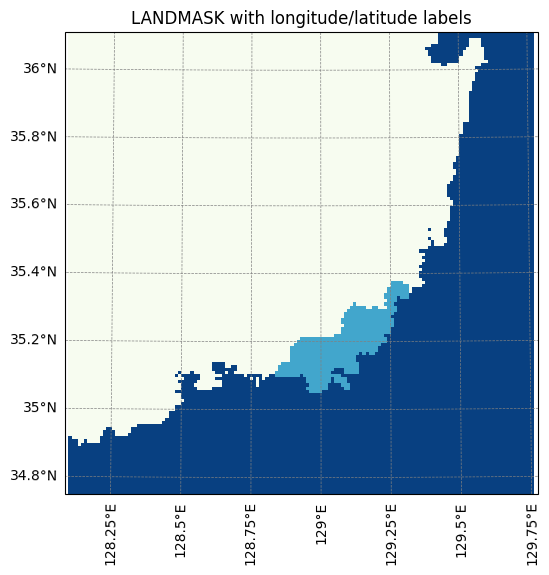

In [ ]:
lat = df["CLAT"].isel(Time=0)
lon = df["CLONG"].isel(Time=0)
lu = df["LU_INDEX"].isel(Time=0)

lambert = ccrs.LambertConformal(
    central_longitude=128.93,
    central_latitude=35.43,
    standard_parallels=(30.0, 60.0)
)

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=lambert)

mesh = ax.pcolormesh(
    lon, lat, lu,
    transform=ccrs.PlateCarree(),
    cmap="GnBu", shading="nearest"
)

#ax.coastlines(resolution="10m", linewidth=0.8)
#ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
#plt.colorbar(mesh, ax=ax, label=str(var.name))

# 영역 맞춤
ax.set_extent([float(lon.min()), float(lon.max()),
               float(lat.min()), float(lat.max())],
              crs=ccrs.PlateCarree())

# --- 경위도 라벨 표시 ---
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linestyle="--", linewidth=0.5, color="gray"
)

# 원하는 방향만 표시
gl.top_labels    = False   # 위쪽 라벨
gl.bottom_labels = True    # 아래쪽 라벨
gl.left_labels   = True    # 왼쪽 라벨
gl.right_labels  = False   # 오른쪽 라벨

# 라벨을 지도 안에서 바깥으로 빼기
gl.x_inline = False
gl.y_inline = False

gl.xlabel_style = {"size": 10, "color": "black"}
gl.ylabel_style = {"size": 10, "color": "black"}

plt.title("LANDMASK with longitude/latitude labels")
plt.show()

In [ ]:
def calculate_eccentricity_and_plot_corrected(wrf_file_path, lu_index_value=13):
    """
    xarray를 사용하여 WRF 파일에서 LU_INDEX 변수가 특정 값인 영역의 이심률을 계산하고,
    NetCDF 뷰어와 동일한 방향으로 시각화합니다.
    """
    try:
        ds = xr.open_dataset(wrf_file_path)
    except FileNotFoundError:
        print(f"오류: 파일을 찾을 수 없습니다: {wrf_file_path}")
        return None

    # LU_INDEX 변수 접근 및 마스크 생성
    # .values를 사용하여 NumPy 배열로 변환
    lu_index_data = ds['LU_INDEX'].isel(Time=0).values
    target_mask_np = (lu_index_data == lu_index_value)

    # regionprops는 (row, col) = (y, x)를 기반으로 속성을 계산합니다.
    # 따라서 target_mask_np는 이 순서 그대로 regionprops에 전달합니다.
    regions = regionprops(target_mask_np.astype(int))

    if not regions:
        print(f"LU_INDEX 값이 {lu_index_value}인 영역을 찾을 수 없습니다.")
        return None

    all_eccentricity_values = []
    for props in regions:
        if props.area > 0:
            all_eccentricity_values.append(props.eccentricity)

    # 시각화: NetCDF 뷰어와 일치하도록 수정
    if all_eccentricity_values:
        largest_region = max(regions, key=lambda r: r.area)

        # regionprops는 (y, x) 순서로 centroid를 반환합니다.
        # 즉, (south_north_index, west_east_index)
        centroid_y, centroid_x = largest_region.centroid
        orientation = largest_region.orientation # 이미지 좌표계에서의 각도
        major_axis = largest_region.major_axis_length
        minor_axis = largest_region.minor_axis_length
        eccentricity = largest_region.eccentricity

        plt.figure(figsize=(10, 10))

        # imshow에 `origin='lower'`를 추가하여 Y축을 아래가 작은 값, 위가 큰 값으로 설정
        # 이렇게 하면 지리적 관점 (남쪽이 아래, 북쪽이 위)과 일치합니다.
        plt.imshow(target_mask_np, cmap='gray', origin='lower')

        # 타원을 그리기 위한 코드
        theta_coords = np.linspace(0, 2 * np.pi, 100)

        # regionprops.orientation은 이미지 좌표계 (y, x) 기준의 각도입니다.
        # 회전된 타원의 x, y 좌표를 계산합니다.
        # 이심률 코드의 타원 그리기 로직은 이미 이미지 좌표계에 맞춰져 있으므로
        # `imshow(origin='lower')`와 함께 사용하면 올바르게 그려집니다.
        x_ellipse_rot = (major_axis / 2) * np.cos(theta_coords) * np.cos(orientation) - \
                        (minor_axis / 2) * np.sin(theta_coords) * np.sin(orientation)
        y_ellipse_rot = (major_axis / 2) * np.cos(theta_coords) * np.sin(orientation) + \
                        (minor_axis / 2) * np.sin(theta_coords) * np.cos(orientation)

        # 중심 좌표를 더해 최종 타원 위치를 계산합니다.
        # centroid_x는 west_east (열), centroid_y는 south_north (행)
        x_ellipse = centroid_x + x_ellipse_rot
        y_ellipse = centroid_y + y_ellipse_rot

        plt.plot(x_ellipse, y_ellipse, color='red', linestyle='--', label='Equivalent Ellipse')
        plt.plot(centroid_x, centroid_y, 'r.', markersize=10, label='Centroid')

        plt.title(f"LU_INDEX {lu_index_value} Region and Equivalent Ellipse\nEccentricity: {eccentricity:.4f}")
        plt.xlabel("West-East (Grid Index)")
        plt.ylabel("South-North (Grid Index)")
        plt.legend()
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.show()

    if all_eccentricity_values:
        avg_eccentricity = np.mean(all_eccentricity_values)
        print(f"LU_INDEX 값이 {lu_index_value}인 모든 영역의 평균 이심률: {avg_eccentricity:.4f}")
        return avg_eccentricity
    else:
        print("이심률을 계산할 수 있는 유효한 영역이 없습니다.")
        return None

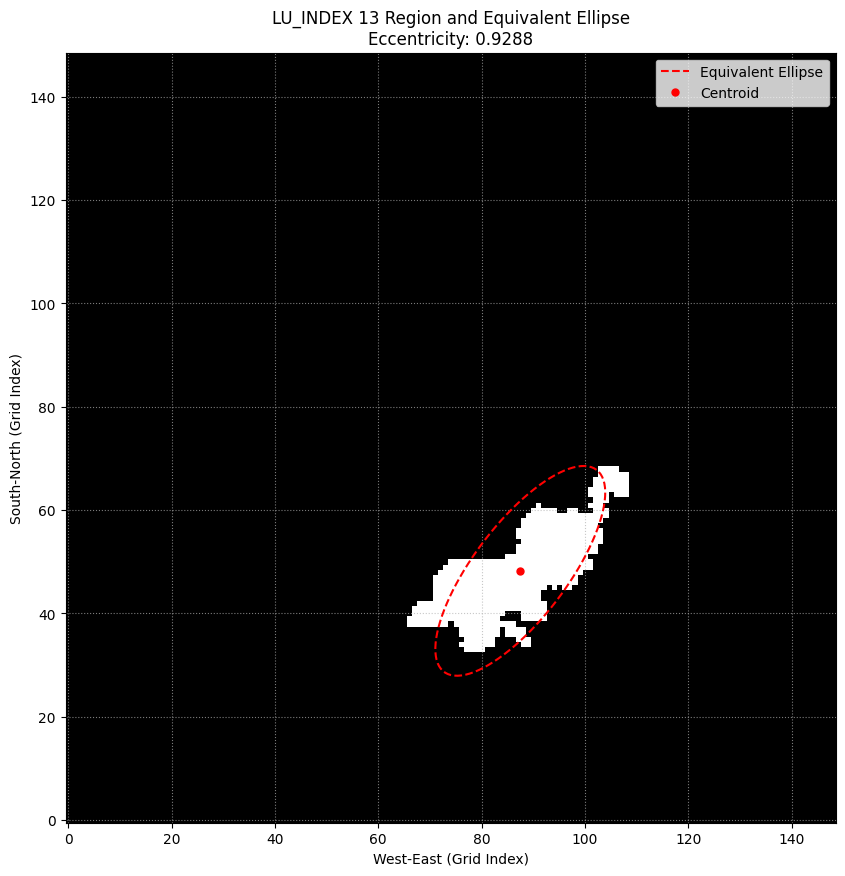

LU_INDEX 값이 13인 모든 영역의 평균 이심률: 0.9288

최종 결과: 0.9288


In [ ]:
if __name__ == "__main__":

    # LU_INDEX가 13인 영역의 이심률 계산 및 출력
    result = calculate_eccentricity_and_plot_corrected(f, lu_index_value=13)

    if result is not None:
        print(f"\n최종 결과: {result:.4f}")

시작 픽셀 집합의 크기: 63 픽셀
최종 시작 픽셀 집합의 크기: 240 픽셀


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52286 (\N{HANGUL SYLLABLE CAJ}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45240 (\N{HANGUL SYLLABLE NAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51089 (\N{HANGUL SYLLABLE JAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

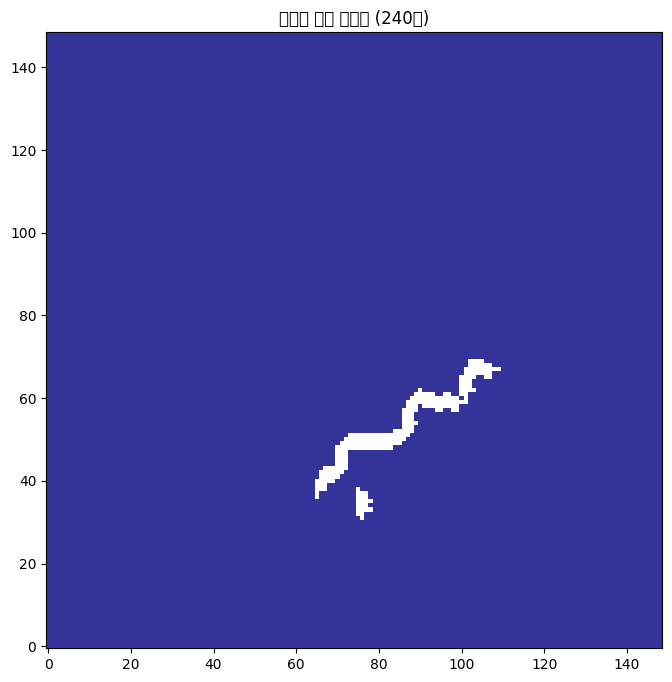

원본 면적: 572 픽셀
목표 면적: 1144 픽셀
pixel: 1144


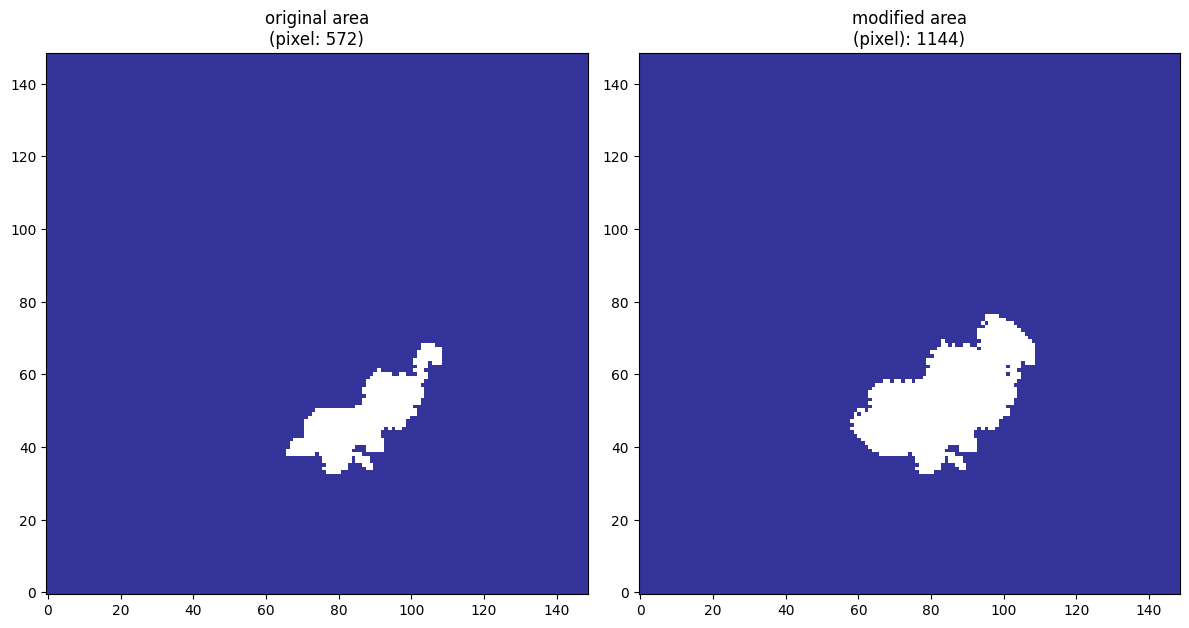


LU_INDEX 데이터가 행 또는 열의 첫 번째 픽셀을 기준으로 확장되었습니다.


In [ ]:
def expand_lu_index_with_or_logic_on_first_pixels(wrf_file_path, lu_index_value=13):
    """
    행 또는 열에서 처음으로 LU_INDEX=13이 되는 픽셀들을 찾아 동시에 확장합니다.
    """
    try:
        ds = xr.open_dataset(wrf_file_path)
    except FileNotFoundError:
        print(f"오류: 파일을 찾을 수 없습니다: {wrf_file_path}")
        return None

    lu_index_da = ds['LU_INDEX'].isel(Time=0)
    landmask_da = ds['LANDMASK'].isel(Time=0)

    original_lu_index_values = lu_index_da.values.copy()
    rows, cols = original_lu_index_values.shape

    # 1. 행을 기준으로 처음으로 LU_INDEX=13이 되는 픽셀 집합 찾기
    first_pixels_from_rows = set()
    for y in range(rows):
        for x in range(cols):
            if original_lu_index_values[y, x] == lu_index_value:
                first_pixels_from_rows.add((y, x))
                break # 해당 행의 첫 번째 픽셀만 찾고 다음 행으로 이동

    # 2. 열을 기준으로 처음으로 LU_INDEX=13이 되는 픽셀 집합 찾기
    # 위에서 아래로 이동하는 방향으로 수정
    first_pixels_from_cols = set()
    for x in range(cols):
        # y축을 감소하는 방향으로 순회 (위에서 아래로)
        for y in range(rows - 1, -1, -1):
            if original_lu_index_values[y, x] == lu_index_value:
                first_pixels_from_cols.add((y, x))
                break

    # 두 집합을 합쳐 최종 시작 픽셀 집합을 만듭니다. (or 조건)
    start_pixels = first_pixels_from_rows.union(first_pixels_from_cols)

    if not start_pixels:
        print(f"LU_INDEX 값이 {lu_index_value}인 픽셀을 찾을 수 없습니다.")
        return None

    print(f"시작 픽셀 집합의 크기: {len(start_pixels)} 픽셀")

    # 3. 시작 픽셀 집합을 (y+1, x-1)과 (y+1, x+1)로 확장
    expanded_start_pixels = start_pixels.copy()
    for y, x in start_pixels:
        # (y+1, x-1) 픽셀 추가
        if y < rows and x - 1 >= 0:
            expanded_start_pixels.add((y, x - 1))
        # (y+1, x+1) 픽셀 추가
        if y < rows and x + 1 < cols:
            expanded_start_pixels.add((y, x + 1))
        # (y+1, x-1) 픽셀 추가
        if y - 1 < rows and x - 1 >= 0:
            expanded_start_pixels.add((y - 1, x - 1))
        # (y+1, x+1) 픽셀 추가
        if y - 1 < rows and x - 1 < cols:
            expanded_start_pixels.add((y + 1 , x - 1))
                # (y+1, x+1) 픽셀 추가
        if y - 1 < rows and x - 2 < cols:
            expanded_start_pixels.add((y - 2 , x - 1))

    start_pixels = expanded_start_pixels

    if not start_pixels:
        print(f"LU_INDEX 값이 {lu_index_value}인 픽셀을 찾을 수 없습니다.")
        return None

    print(f"최종 시작 픽셀 집합의 크기: {len(start_pixels)} 픽셀")

    # 3. 시작 픽셀만 시각화
    start_pixel_mask = np.zeros_like(original_lu_index_values, dtype=bool)
    for y, x in start_pixels:
        start_pixel_mask[y, x] = True

    plt.figure(figsize=(8, 8))
    plt.imshow(start_pixel_mask, cmap='terrain', origin='lower')
    plt.title(f'찾아낸 시작 픽셀들 ({len(start_pixels)}개)')
    plt.show()

    # 3. 원본 면적 및 목표 면적 계산
    original_area = np.sum(original_lu_index_values == lu_index_value)
    target_area = original_area * 2

    print(f"원본 면적: {original_area} 픽셀")
    print(f"목표 면적: {target_area} 픽셀")

    # 4. 확장 시작: (y+1, x-1) 방향으로 확장
    new_lu_index_values = original_lu_index_values.copy()
    current_area = original_area

    current_expansion_pixels = start_pixels.copy()

    while current_area < target_area:
        new_pixels_to_add_in_this_round = set()

        for y, x in current_expansion_pixels:
            next_y, next_x = y + 1, x - 1

            if 0 <= next_y < rows and 0 <= next_x < cols and landmask_da.values[next_y, next_x] == 1:
                if new_lu_index_values[next_y, next_x] != lu_index_value:
                    new_pixels_to_add_in_this_round.add((next_y, next_x))

        if not new_pixels_to_add_in_this_round:
            print("더 이상 확장할 유효한 육지 픽셀이 없어 확장을 중단합니다.")
            break

        for y, x in new_pixels_to_add_in_this_round:
            if current_area < target_area:
                new_lu_index_values[y, x] = lu_index_value
                current_area += 1
            else:
                break

        current_expansion_pixels = new_pixels_to_add_in_this_round

    # 5. 결과 시각화
    final_area = np.sum(new_lu_index_values == lu_index_value)
    print(f"pixel: {final_area}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_lu_index_values == lu_index_value, cmap='terrain', origin='lower')
    axes[0].set_title(f'original area\n(pixel: {original_area})')

    axes[1].imshow(new_lu_index_values == lu_index_value, cmap='terrain', origin='lower')
    axes[1].set_title(f'modified area\n(pixel): {final_area})')

    plt.tight_layout()
    plt.show()

    modified_lu_index_da = xr.DataArray(
        new_lu_index_values,
        dims=lu_index_da.dims,
        coords=lu_index_da.coords,
        attrs=lu_index_da.attrs
    )
    return modified_lu_index_da

# 스크립트 실행
if __name__ == "__main__":
    new_file_path = '/content/drive/MyDrive/UHI/geo_em.00.nc'
    expanded_data = expand_lu_index_with_or_logic_on_first_pixels(f, lu_index_value=13)

    if expanded_data is not None:
        print("\nLU_INDEX 데이터가 행 또는 열의 첫 번째 픽셀을 기준으로 확장되었습니다.")

In [ ]:
# 다시 netCDF 파일로 저장
df_new = df
#print(df_new)

# 시간 차원 추가
expanded_with_time = expanded_data.expand_dims(Time=df.Time)
df_new['LU_INDEX'] = expanded_with_time

f_new = '/content/drive/MyDrive/UHI/geo_em.00.nc'

#print(type(df_new))
df_new.to_netcdf(f_new)

/tmp/ipython-input-3919172343.py:12: UserWarning: Unlimited dimension(s) {'time'} declared in 'dataset.encoding', but not part of current dataset dimensions. Consider removing {'time'} from 'dataset.encoding'.
  df_new.to_netcdf(f_new)


In [ ]:
df_new = xr.open_dataset(f_new)
print(df_new["LU_INDEX"])

<xarray.DataArray 'LU_INDEX' (Time: 1, south_north: 149, west_east: 149)> Size: 89kB
[22201 values with dtype=float32]
Coordinates:
  * Time     (Time) int64 8B 0
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    units:        category
    description:  Dominant category
    stagger:      M
    sr_x:         1
    sr_y:         1


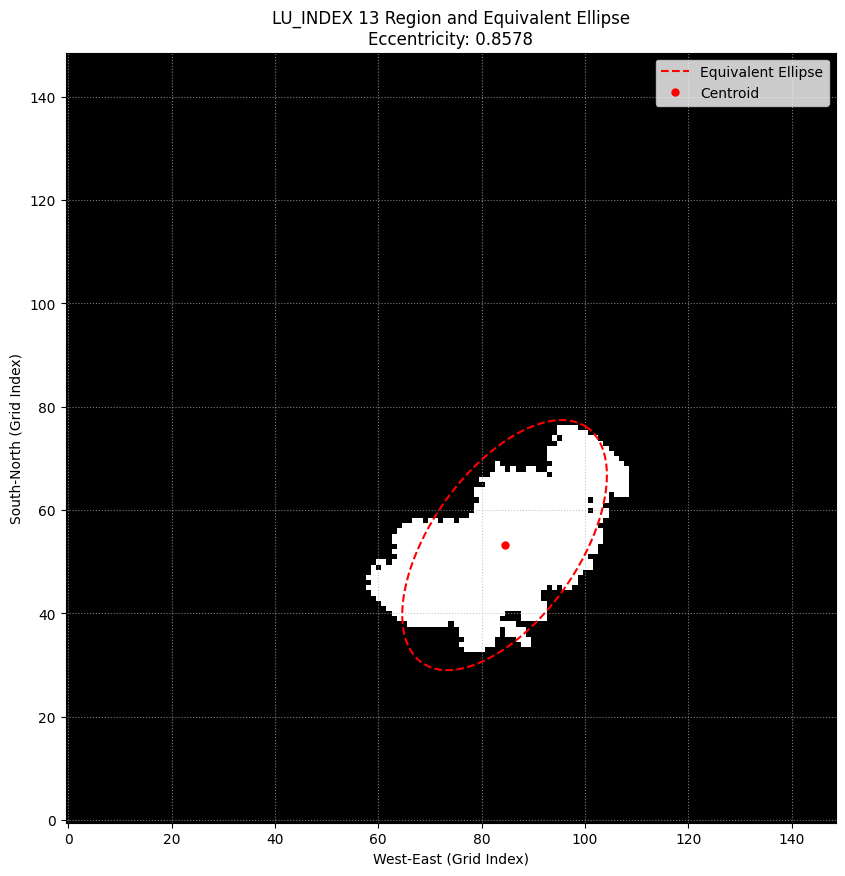

LU_INDEX 값이 13인 모든 영역의 평균 이심률: 0.8578

최종 결과: 0.8578


In [ ]:
if __name__ == "__main__":

    # LU_INDEX가 13인 영역의 이심률 계산 및 출력
    result = calculate_eccentricity_and_plot_corrected(f_new, lu_index_value=13)

    if result is not None:
        print(f"\n최종 결과: {result:.4f}")